In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt

In [28]:
def draw_plots(img_1, title1, img_2, title2, gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if gray:
        ax1.imshow(img_1, cmap='gray')
    else:
        ax1.imshow(img_1)
    ax1.set_title(title1, fontsize=50)
    if gray:
        ax2.imshow(img_2, cmap='gray')
    else:
        ax2.imshow(img_2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [48]:
def draw_img_variants(img, scheme = 'HLS'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:, : , 0]
    l_channel = hls[:, : , 1]
    s_channel = hls[:, : , 2]    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title("Original")
    ax1.imshow(img)
    ax2.set_title("H Channel")
    ax2.imshow(h_channel)
    ax3.set_title("L Channel")
    ax3.imshow(l_channel)
    ax4.set_title("S Channel")
    ax4.imshow(s_channel)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Calibrate Camera

**Images actually have 6*9 corners**

In [5]:
images = glob.glob('camera_cal/calibration*.jpg')

In [22]:
def calibrate_camera():
    objpoints = []
    imgpoints = []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    img_shape = None
    for img_file in images:
        img = mpimg.imread(img_file)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_shape = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape,None,None)
    return (mtx, dist)

In [23]:
mtx, dist = calibrate_camera()

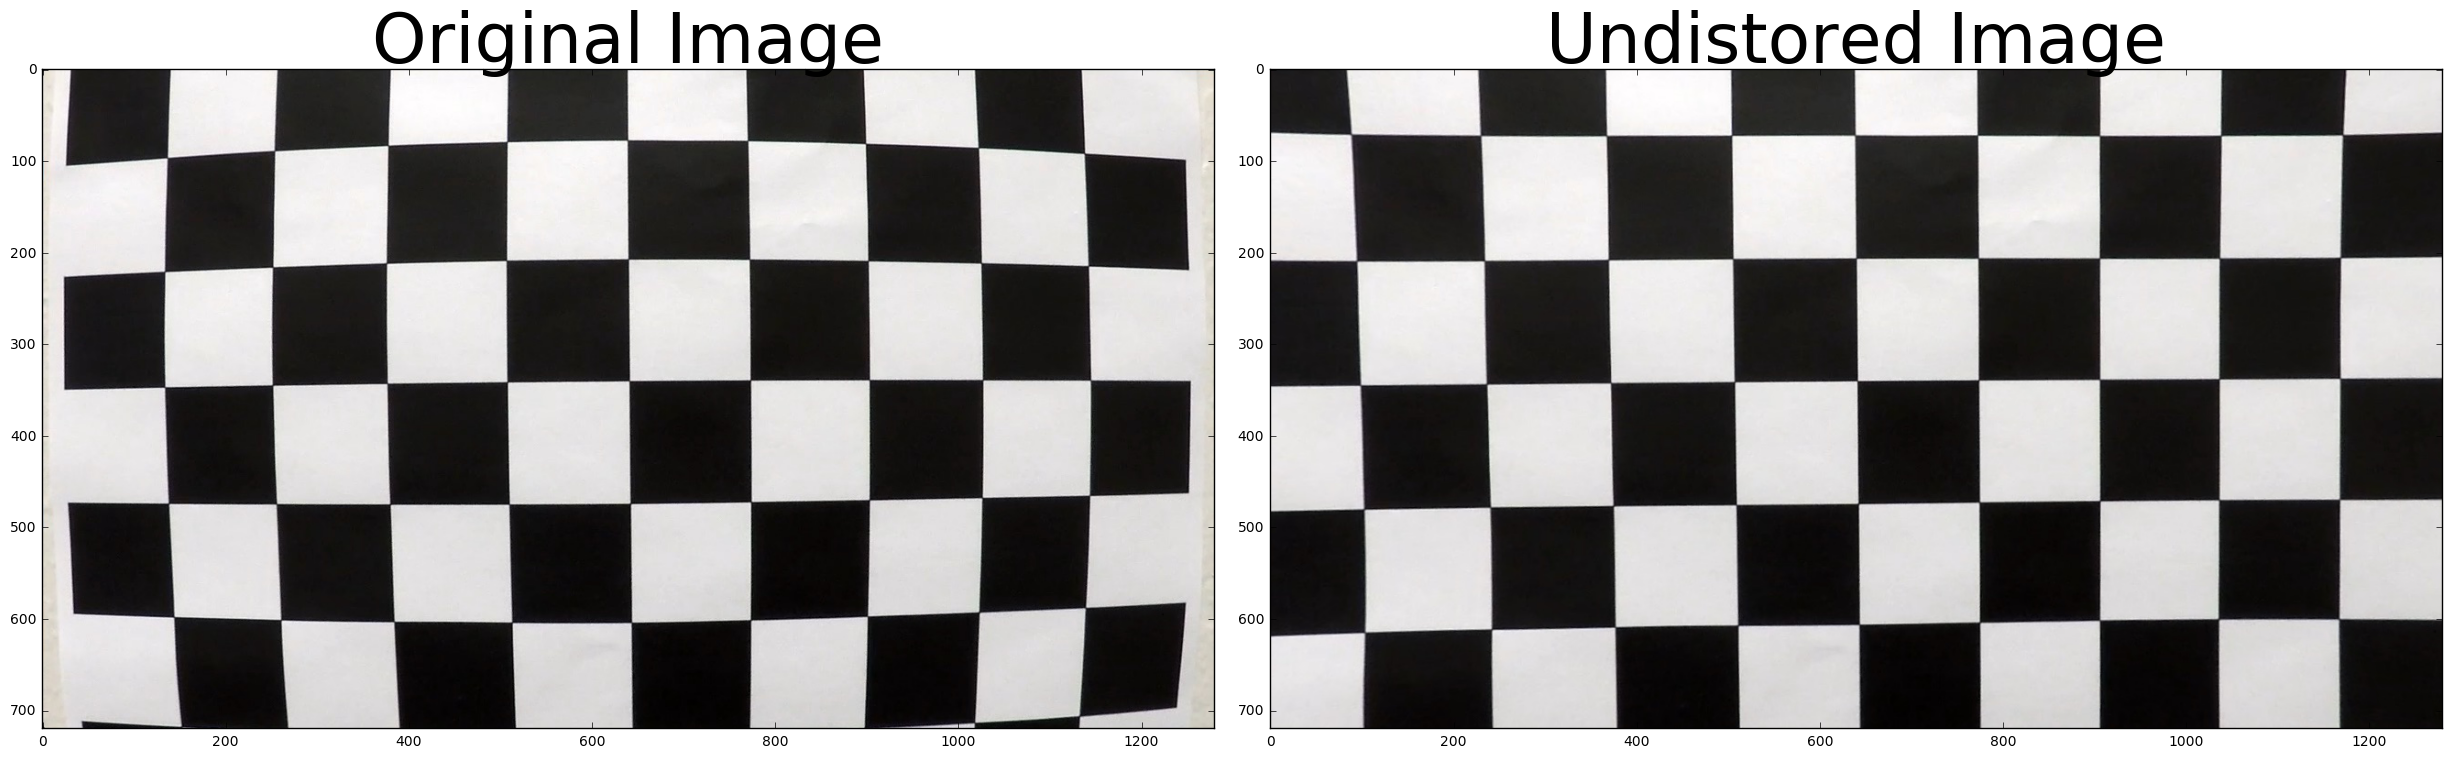

In [24]:
img_test = mpimg.imread('camera_cal/calibration1.jpg')

uimage = cv2.undistort(img_test, mtx, dist, None, mtx)
draw_plots(img_test, "Original Image", uimage, "Undistored Image")

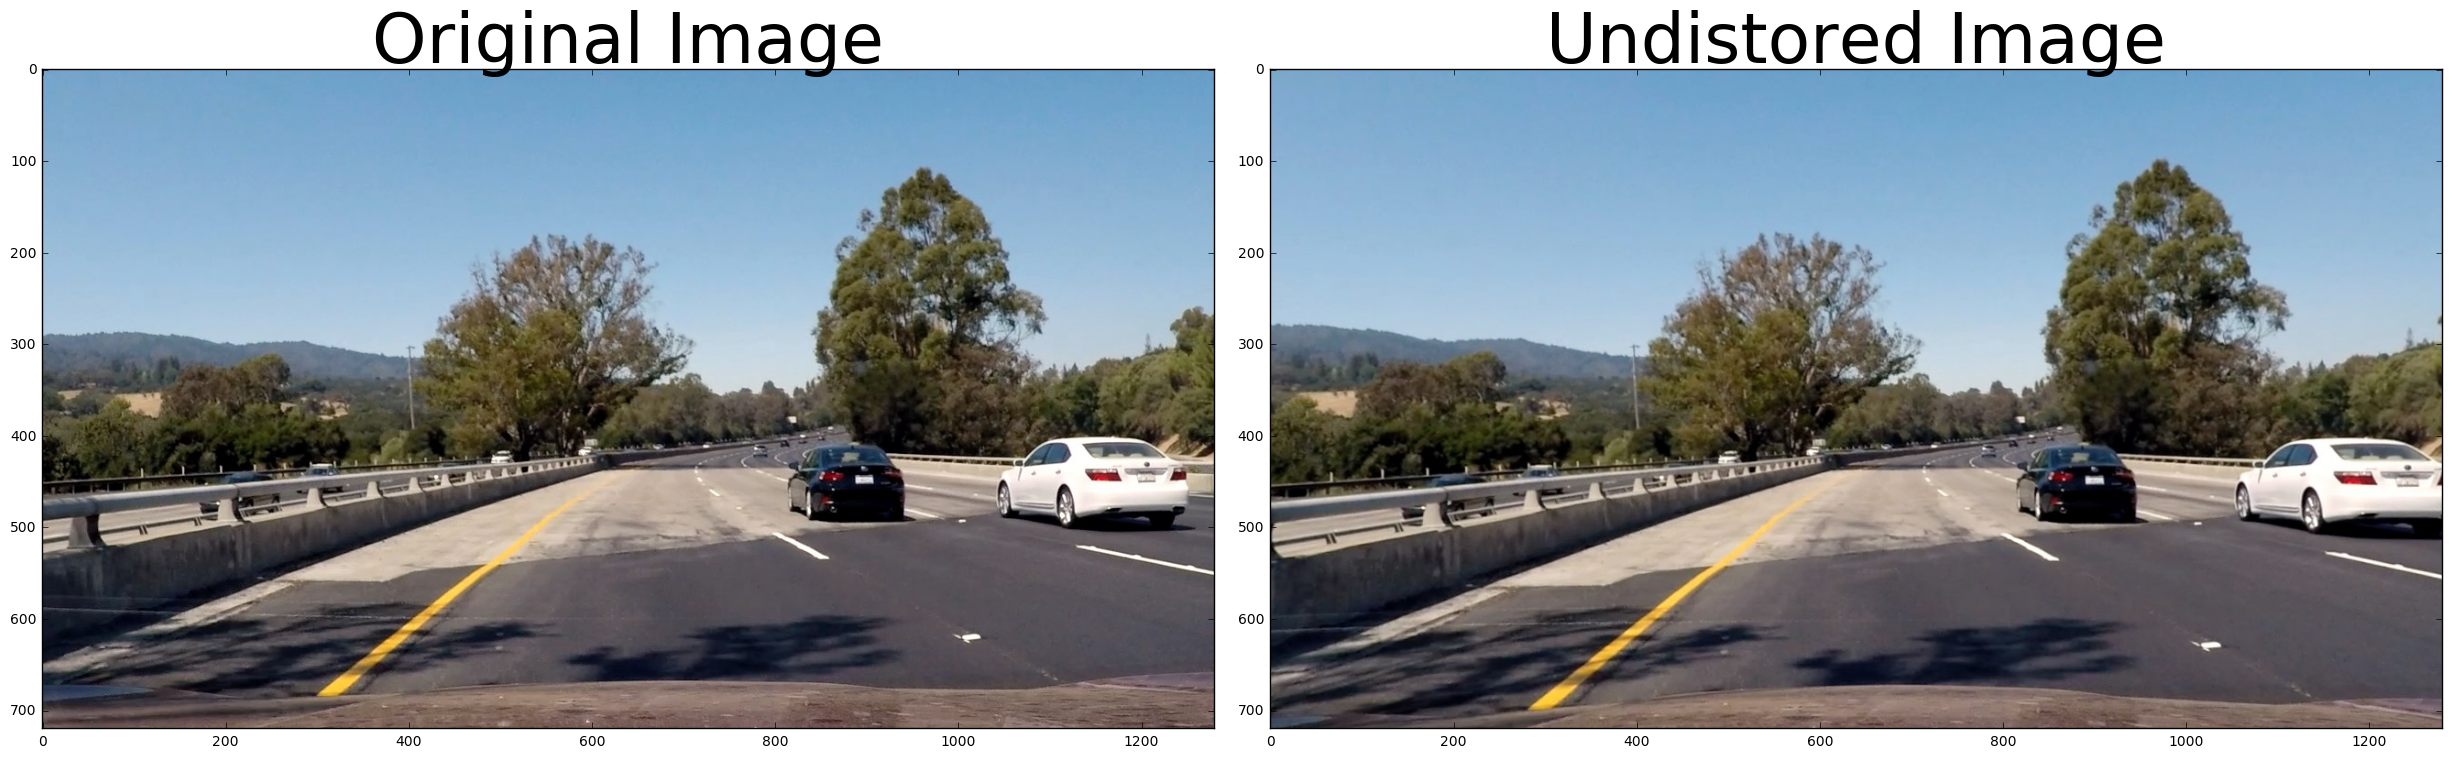

In [25]:
img_test = mpimg.imread('test_images/test4.jpg')
uimage = cv2.undistort(img_test, mtx, dist, None, mtx)
draw_plots(img_test, "Original Image", uimage, "Undistored Image")

In [26]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    gradx = 1 if orient == 'x' else 0
    grady = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, gradx, grady)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8( 255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [27]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [28]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print(ret)
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(gray, (nx, ny), corners, ret)
        plt.imshow(gray)
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])
        # 4) If corners found: 
                # a) draw corners
                # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                     #Note: you could pick any four of the detected corners 
                     # as long as those four corners define a rectangle
                     #One especially smart way to do this would be to use four well-chosen
                     # corners that were automatically detected during the undistortion steps
                     #We recommend using the automatic detection of corners in your code
                # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
                # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
                # e) use cv2.warpPerspective() to warp your image to a top-down view
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
                                     
        return warped, M


In [29]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

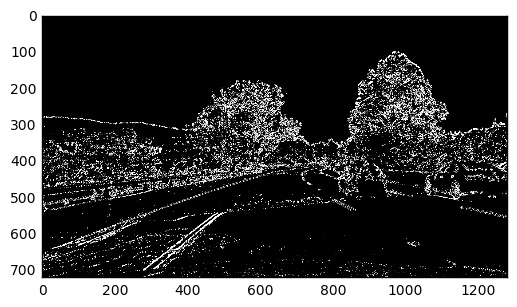

In [30]:
gradx = abs_sobel_thresh(uimage, orient='x', thresh_min=10, thresh_max=100)
grady = abs_sobel_thresh(uimage, orient='y', thresh_min=10, thresh_max=100)
mag_binary = mag_thresh(uimage, sobel_kernel=7, mag_thresh=(30, 100))
dir_binary = dir_threshold(uimage, sobel_kernel=7, thresh=(np.pi/1, np.pi/2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

In [4]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

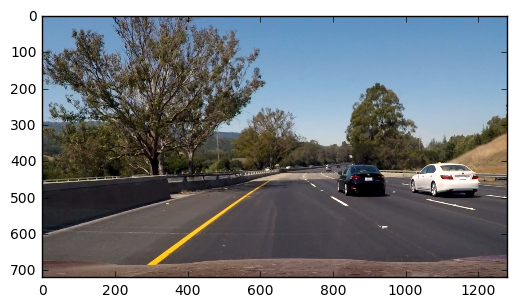

In [42]:

img_test = mpimg.imread('test_images/test6.jpg')
plt.imshow(img_test)

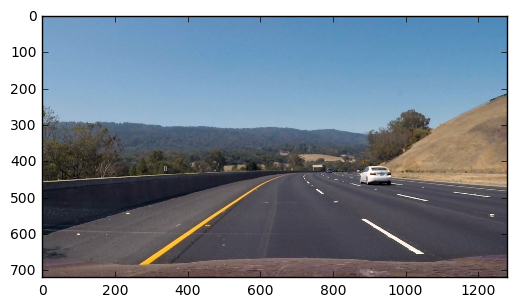

In [60]:
img_test = mpimg.imread('test_images/test3.jpg')
plt.imshow(img_test)

### Bird's Eye view (Perspective Transform)

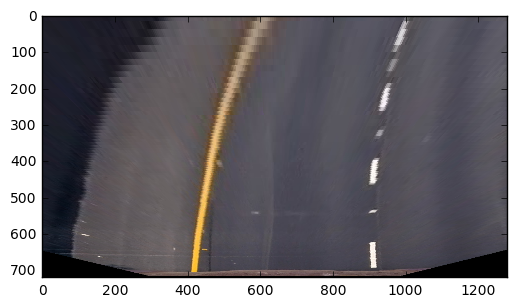

In [61]:
src = np.float32([[800, 500], [950, 585], [450, 585], [550, 500]])
dst = np.float32([[935, 500], [935, 650], [450, 650], [450, 500]])
warped = warper(img_test, src, dst)
%matplotlib inline
plt.imshow(warped)

# Channel Exploration of images

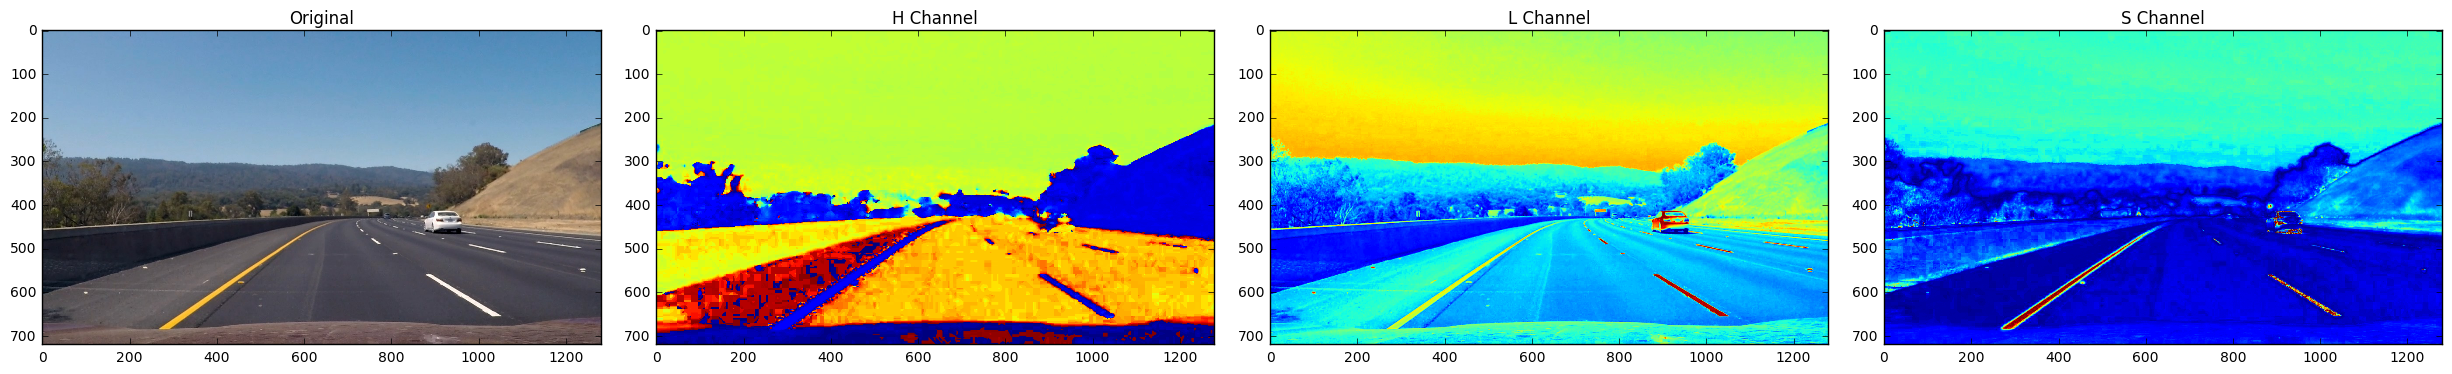

In [62]:
draw_img_variants(img_test)

### Color and Threshold Gradient

In [69]:
def color_gradient_threshold(img, s_thresh=(150, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

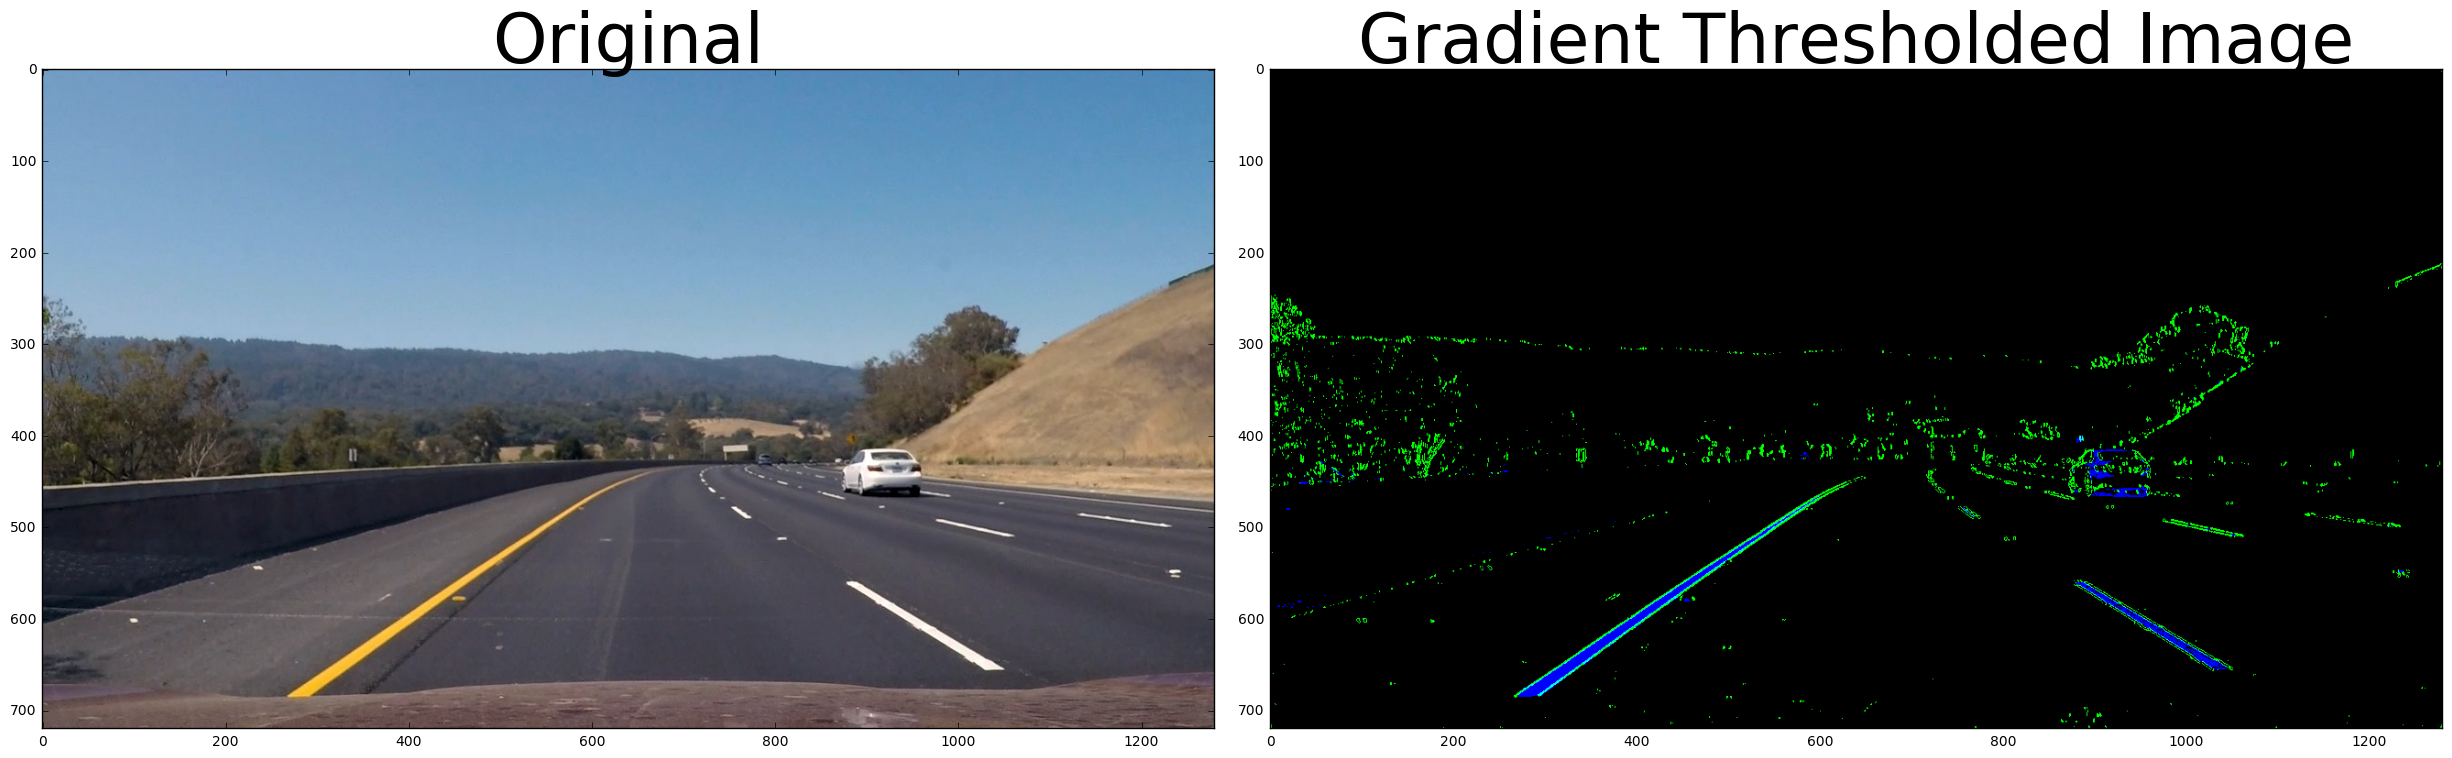

In [70]:
gradient_image = color_gradient_threshold(img_test)
draw_plots(img_test, 'Original', gradient_image, 'Gradient Thresholded Image')

In [71]:
warped_img = warper(gradient_image, src, dst)
plt.imshow(warped_img)